# Along-contour SSH=-1.2m plots

Smoothing plot for methods

RS,FS and transport comparison Fig 6.4

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import scipy.stats as ss
from collections import OrderedDict
from matplotlib import gridspec

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
from correlation import Compute_Correlation

import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45627/status,
Dashboard: /proxy/45627/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46159,Workers: 4
Dashboard: /proxy/45627/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:35927,Total threads: 4
Dashboard: /proxy/34973/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:42289,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load important parameters

In [4]:
year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)

In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 2.65 s, sys: 875 ms, total: 3.52 s
Wall time: 18.1 s


In [7]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
MKE = xr.open_dataset(save_dir+'MKE_10yr.nc').MKE
EKE = xr.open_dataset(save_dir+'EKE_10yr.nc').EKE
Reynolds = xr.open_dataset(save_dir+'Reynolds_10yr_fulldepth.nc').Reynolds
Form_stress = xr.open_dataset(save_dir+'Form_stress_10yr_fulldepth.nc').Form_stress
h_bar = xr.open_dataset(save_dir+'h_bar_10yr.nc').h_bar

In [8]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

In [45]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 13})


In [10]:
j_contour = 'L'
lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1

6.2746018951807905
32.93032537855146 40.37801995445322
0.9235988342487127
22.857750676270363 29.925203977339873


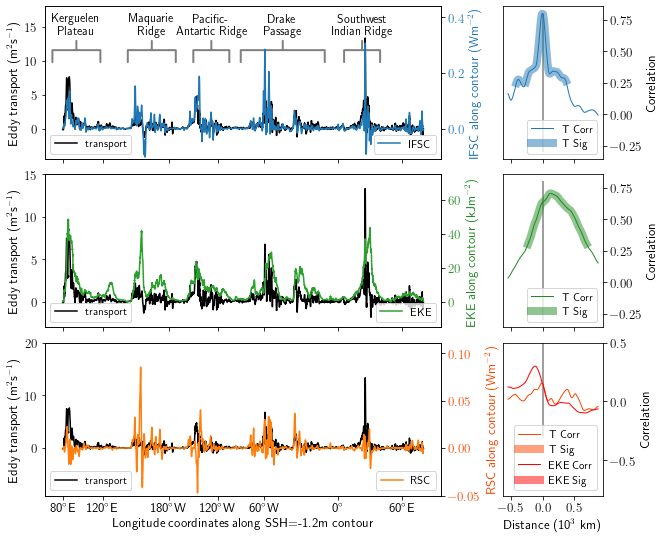

In [28]:
j_contour = 'L'
N=10
if contour_dict[j_contour]['shifted']==True:
    suffix = '_shiftedback'
else:
    suffix = ''
vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff.sel(hotspot = 'total')
SSH = contour_dict[j_contour]['SSH']
rhoslice = slice(1032.2,1032.5)

eddy_notcumsum = -(vh_eddy).sel(isopycnal_bins=rhoslice).sum('isopycnal_bins').fillna(0)
segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length
y = uniform_filter1d(eddy_notcumsum, size=N)/segment_length
EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').Form_contour
EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
EKE = uniform_filter1d(EKE, size=N)/segment_length
z_scaled = y.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(y)
EKE_scaled = EKE.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(EKE)
c_cor = Compute_Correlation(z_scaled,EKE_scaled)
c_cor2 = Compute_Correlation(EKE_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)
distance = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_distance_along_contour.nc').distance
distance_small = distance[0:len(corr)]
distance_combined = np.append(-np.flip(distance_small)[:-1],distance_small)

f, ((ax, ax_inset), (axE,ax_insetE), (axR,ax_insetR)) = plt.subplots(3, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize = (10,9), sharex = 'col')
ax.plot(distance,y, color = 'k', label = 'transport')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('IFSC along contour (Wm$^{-2}$)', color='C0')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='C0')
ax2.plot(distance,EKE, color = 'C0', label = 'IFSC')

ax_inset.plot(distance_combined[1550:1800],corr_combined_E[1550:1800],'C0',linewidth=1,label='T Corr')
ax_inset.plot(distance_combined[1550:1800],(corr_combined_E*sig_combined_E)[1550:1800], color='C0',linewidth=8,alpha=0.5,label="T Sig")
ax_inset.vlines(0,-0.3,0.8, color = 'grey')
ax.legend(loc = 'lower left', fontsize = 11)
ax2.legend(loc = 'lower right', fontsize = 11)

ax_inset.legend(loc = 'lower right', fontsize = 11)
ax.set_xlabel('')
ax_inset.set_xlabel('')
ax.set_ylabel('Eddy transport (m$^2$s$^{-1}$)')
ax_inset.yaxis.tick_right()
ax_inset.yaxis.set_label_position("right")
ax_inset.set_ylabel('Correlation')

ax2.set_ylim(-0.11,0.44)
ax.set_ylim(-4.5,18)
##############same for Reynolds ###############
EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').Reynolds_contour
EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
N=10
EKE = uniform_filter1d(EKE, size=N)/segment_length
z_scaled = y.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(y)
EKE_scaled = EKE.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(EKE)
c_cor = Compute_Correlation(z_scaled,EKE_scaled)
c_cor2 = Compute_Correlation(EKE_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)

axR.plot(distance,y, color = 'k', label = 'transport')
ax2 = axR.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('RSC along contour (Wm$^{-2}$)', color='orangered')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='orangered')
ax2.plot(distance,EKE, color = 'C1', label = 'RSC')

ax_insetR.plot(distance_combined[1550:1800],corr_combined_E[1550:1800],'orangered',linewidth=1,label='T Corr')
ax_insetR.plot(distance_combined[1550:1800],(corr_combined_E*sig_combined_E)[1550:1800], color='orangered',linewidth=8,alpha=0.5,label="T Sig")
ax_insetR.vlines(0,-0.3,0.5, color = 'grey')
ax2.legend(loc = 'lower right', fontsize = 11)
axR.legend(loc = 'lower left', fontsize = 11)

axR.set_xlabel('')
ax_insetR.set_xlabel('')
axR.set_ylabel('Eddy transport (m$^2$s$^{-1}$)')
ax_insetR.yaxis.tick_right()
ax_insetR.yaxis.set_label_position("right")
ax_insetR.set_ylabel('Correlation')

ax2.set_ylim(-0.05,0.1111)
axR.set_ylim(-9,20)


############ SAME FOR EKE ###############

EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').EKE_contour
EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').values/segment_length.values
z_scaled = y/np.max(y)
EKE_scaled = EKE/np.max(EKE)
c_cor = Compute_Correlation(z_scaled,EKE_scaled)
c_cor2 = Compute_Correlation(EKE_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
print(max(t))
print(min(N),max(N))
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)

axE.plot(distance,y, color = 'k', label = 'transport')
ax2 = axE.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('EKE along contour (kJm$^{-2}$)', color='forestgreen')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='forestgreen')
ax2.plot(distance,EKE/1e3, color = 'C2', label = 'EKE')

ax_insetE.plot(distance_combined[1550:1800],corr_combined_E[1550:1800],'forestgreen',linewidth=1,label='T Corr')
ax_insetE.plot(distance_combined[1550:1800],(corr_combined_E*sig_combined_E)[1550:1800], color='forestgreen',linewidth=8,alpha=0.5,label="T Sig")
ax_insetE.vlines(0,-0.3,0.8, color = 'grey')
axE.legend(loc = 'lower left', fontsize = 11)
ax2.legend(loc = 'lower right', fontsize = 11)
axR.set_xticks(distance.values[distance_indices.astype(int)[:-1]])
axR.set_xticklabels(['80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E']);
axR.set_xlabel('Longitude coordinates along SSH=-1.2m contour')
axE.set_xlabel('')

ax_insetE.legend(loc = 'lower right', fontsize = 11)
ax_insetR.set_xlabel('Distance (10$^3$ km)')
ax_insetE.set_xlabel('')

axE.set_ylabel('Eddy transport (m$^2$s$^{-1}$)')
ax_insetE.yaxis.tick_right()
ax_insetE.yaxis.set_label_position("right")
ax_insetE.set_ylabel('Correlation')

ax.annotate('Kerguelen \n Plateau', xy=(0.08, 0.70), xytext=(0.08, 0.8), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2.0, lengthB=1', lw=2.0, color = 'grey'))
ax.annotate('Maquarie \n Ridge', xy=(0.27, 0.70), xytext=(0.27, 0.8), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2.0, lengthB=1', lw=2.0, color = 'grey'))
ax.annotate('Pacific-\n Antartic Ridge', xy=(0.42, 0.70), xytext=(0.42, 0.8), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=1', lw=2.0, color = 'grey'))
ax.annotate('Drake \n Passage', xy=(0.6, 0.70), xytext=(0.6, 0.8), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=1', lw=2.0, color = 'grey'))
ax.annotate('Southwest \n Indian Ridge', xy=(0.8, 0.70), xytext=(0.8, 0.8), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=1', lw=2.0, color = 'grey'))
ax2.set_ylim(-15,75)
axE.set_ylim(-3,15)

### compare reynolds and EKE ###
z = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').EKE_contour
z = z.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').values/segment_length.values
Reynolds_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').Reynolds_contour
Reynolds_contour = Reynolds_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
N=10
Reynolds_contour = uniform_filter1d(Reynolds_contour, size=N)/segment_length
z_scaled = z/np.max(z)
Reynolds_scaled = Reynolds_contour.where(Reynolds_contour!=np.inf).where(Reynolds_contour!=-np.inf).fillna(0)/np.max(Reynolds_contour)
c_cor = Compute_Correlation(z_scaled,Reynolds_scaled)
c_cor2 = Compute_Correlation(Reynolds_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
print(max(t))
print(min(N),max(N))
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)
ax_insetR.plot(distance_combined[1550:1800],corr_combined_E[1550:1800],'red',linewidth=1,label='EKE Corr')
ax_insetR.plot(distance_combined[1550:1800],(corr_combined_E*sig_combined_E)[1550:1800], color='red',linewidth=8,alpha=0.5,label="EKE Sig")
ax_insetR.legend(loc = 'lower right', fontsize = 11)
ax_insetR.set_ylim(-0.8,0.5)


plt.subplots_adjust(wspace = 0.25, hspace = 0.1)
plt.show()
f.subplots_adjust(bottom =0.15)

f.savefig('Fig9-FSEKERScorr_SSH1.2.png',dpi = 400)

# Smoothing and mean justification

In [11]:
vh_eddy_Eulerian = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_L_vh_eddy_Eulerian_method.nc').vh_eddy_Eulerian

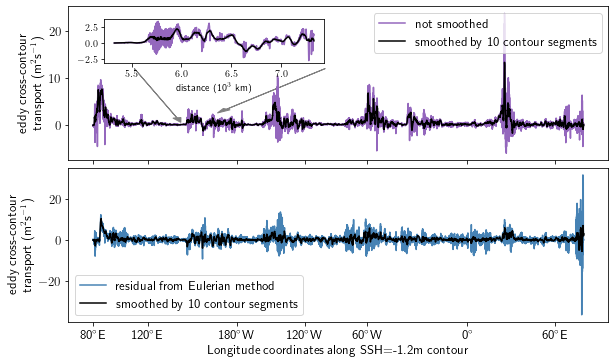

In [49]:
N=10
j_contour ='L'
rhoslice = slice(1032.2,1032.5)
if contour_dict[j_contour]['shifted']==True:
    suffix = '_shiftedback'
else:
    suffix = ''
vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy

eddy_notcumsum = -(vh_eddy).sel(isopycnal_bins=rhoslice).sum('isopycnal_bins')
y = uniform_filter1d(eddy_notcumsum, size=N)
fig, axes = plt.subplots(2,1,figsize = (10,6), sharex = 'col', gridspec_kw={'height_ratios': [2, 2]})
#ax = fig.add_axes([0,0,1,1])
distance = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_distance_along_contour.nc').distance
segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length

axes[0].plot(distance,eddy_notcumsum/segment_length, color = 'C4', label = 'not smoothed')
axes[0].plot(distance,y/segment_length.values, color = 'k', label = 'smoothed by 10 contour segments')
axes[0].legend(loc = 'upper right')
axes[0].set_ylabel('eddy cross-contour \n transport (m$^2$s$^{-1}$)')
axes[0].set_title('')
ax_inset = fig.add_axes([0.2,0.75,0.305,0.1])
ax_inset.plot(distance[1000:1400],eddy_notcumsum[1000:1400]/segment_length[1000:1400], color = 'C4', label = 'not smoothed - $\overline{v^\prime h^\prime}$')
ax_inset.plot(distance[1000:1400],y[1000:1400]/segment_length.values[1000:1400], color = 'k', label = 'smoothed by 10 contour segments')
ax_inset.set_xlabel('distance (10$^3$ km)', fontsize = 10)
ax_inset.tick_params(axis='x', labelsize= 10)
ax_inset.tick_params(axis='y', labelsize= 10)

axes[0].arrow(2.5,12,2.8,-11.5, color = 'grey', head_length = 1, head_width = 0.5, length_includes_head = True)
axes[0].arrow(14,12,-6.5,-9.5, color = 'grey', head_length = 1, head_width = 0.5, length_includes_head = True)

axes[1].plot(distance,-vh_eddy_Eulerian.sel(isopycnal_bins=rhoslice).sum('isopycnal_bins')/segment_length, label = 'residual from Eulerian method',
            color = 'steelblue')

axes[1].set_xticks(distance.values[distance_indices.astype(int)[:-1]])
eddy_notcumsum = -(vh_eddy_Eulerian).sel(isopycnal_bins=rhoslice).sum('isopycnal_bins')
y = uniform_filter1d(eddy_notcumsum, size=N)
axes[1].plot(distance,y/segment_length.values, color = 'k', label = 'smoothed by 10 contour segments')

axes[1].set_xticklabels(['80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E']);
axes[1].set_xlabel('Longitude coordinates along SSH=-1.2m contour')
axes[0].set_xlabel('')
axes[1].set_ylabel('eddy cross-contour \n transport (m$^2$s$^{-1}$)')
axes[1].legend()
fig.subplots_adjust(bottom = 0.15, left = 0.15, hspace = 0.05)
fig.savefig('Fig3-smoothing_mean.png',dpi = 400)